# What is recordclass

[Recordclass](https://pypi.python.org/pypi/recordclass) is a library for creation of `record`-like classes &ndash; "mutable" analog of [collections.namedtuple](https://docs.python.org/3/library/collections.html).
They support same API as namedtuples. In addition they also support assignment operations.

It can be installed via `pip` command:
```
pip3 install recordclass
```

In order to start import factory functions:

In [1]:
from recordclass import recordclass, make_dataclass

from sys import getsizeof as sizeof
from collections import namedtuple

import sys
print(sys.version)

3.9.9 (main, Dec 16 2021, 23:13:29) 
[GCC 11.2.0]


## Recordclass-based classes

The factory function `recordclass` is almost analog of `collection.namedtuple`, but can be mutable.

They are created by the same way as namedtuples:

In [2]:
R = recordclass("R", "a b c d e f g h")
r = R(*range(8))

Record has the same size as the equivalent namedtuple:

In [3]:
R2 = namedtuple("R", "a b c d e f g h")
r2 = R2(*range(1,9))
print("recordclass: sizeof:", sizeof(r))
print("namedtuple:  sizeof:", sizeof(r2))

recordclass: sizeof: 80
namedtuple:  sizeof: 104


The size of recordclass-based instance is less because it not participate in cyclic garbage collection by default.
Tuples have a field for the the number of items, recordclass-based instances havn't.

Record has the same text representation as namedtuple:

In [4]:
print(repr(r))
print(str(r))

R(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7)
R(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7)


It support access to field both by attribute and by index:

In [5]:
print('By index:', r.a, r.b, r.c, r.d, r.e, r.f, r.g, r.h)
print('By name: ', r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7])

By index: 0 1 2 3 4 5 6 7
By name:  0 1 2 3 4 5 6 7


Record can change the value of any it's field inplace:

In [6]:
r.a, r.b, r.c, r.d, r.e, r.f, r.g, r.h = r.a, 2*r.b, 3*r.c, 4*r.d, 5*r.e, 6*r.f, 7*r.g, 8*r.h
print(r)

r1 = r._replace(a=100, h=1000) # same as r.a=100; r.h=1000
print(r1)
print('Are they same?', r1 is r)

R(a=0, b=2, c=6, d=12, e=20, f=30, g=42, h=56)
R(a=100, b=2, c=6, d=12, e=20, f=30, g=42, h=1000)
Are they same? True


Records supports iterative unpacking and iteration over values in fields:

In [7]:
a, b, c, d, e, f, g, h = r
print(a, b, c, d, e, f, g, h)

for v in r:
    print(v, end=" ")

100 2 6 12 20 30 42 1000
100 2 6 12 20 30 42 1000 

As namedtuple it can be converted to dict (infact to OrdeedDict as namedtuple):

In [8]:
r._asdict()

{'a': 100, 'b': 2, 'c': 6, 'd': 12, 'e': 20, 'f': 30, 'g': 42, 'h': 1000}

Records are pickable and unpickable"

In [9]:
import pickle
r_pickled = pickle.dumps(r)
r_unpickled = pickle.loads(r_pickled)
r == r_unpickled

True

Recordclasses has `__attrs__` attribute and an empty `__slots__`:

In [10]:
print(R.__fields__)

('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h')


Recordclass provide also general approach for contsruction of memory efficient configurable classes.

There is simple example:

In [28]:
from recordclass import dataobject

class Point(dataobject):
    x:int
    y:int

It support only read/write access to the fields via `__getattr__/__setattr__` protocol. It doesn't support access to the fields by index:

In [30]:
p = Point(1, 2)
p.x = 100
p.y = 200
print(p)
try:
    p[0]
except TypeError as ex:
    print(ex)

try:
    iter(p)
except TypeError as ex:
    print(ex)


Point(x=100, y=200)
object Point does not support assignment
'Point' object is not iterable


`Point` have minimal memory footprint: `sizeof(PyObject_HEAD) + 3*sizeof(*PyObject)`.

In [13]:
class PointSlots:
    __slots__ = 'x', 'y'
    x:int
    y:int
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

from typing import NamedTuple
class PointNT(NamedTuple):
    x:int
    y:int

In [14]:
p = Point(1,2)
p_s = PointSlots(1,2)
p_nt = PointNT(1,2)

from sys import getsizeof as sizeof
print('dataobject:', sizeof(p))
print('class with __slots__:', sizeof(p_s))
print('NamedTuple:', sizeof(p_nt))

dataobject: 32
class with __slots__: 48
NamedTuple: 56


One can add iterable, sequence and mapping protocols to the class:

In [37]:
# add support for iter without support for sequence protocol
class PointIterable(dataobject, iterable=True):
    x:int
    y:int
   
p = PointIterable(1, 2)
print(p.x, p.y)

try:
    p[0]
except TypeError as ex:
    print(ex)

for v in p:
    print(v)

1 2
object PointIterable does not support assignment
1
2


In [38]:
# add support for sequence protocol
class PointIterable(dataobject, sequence=True):
    x:int
    y:int
   
p = PointIterable(1, 2)
print(p.x, p.y)
print(p[0], p[1])
print(p[-1], p[-2])

1 2
1 2
2 1


In [39]:
# add support for mapping protocol only
class PointMapping(dataobject, mapping=True):
    x:int
    y:int
   
p = PointMapping(1, 2)
print(p.x, p.y)
print(p['x'], p['y'])

try:
    p[0]
except TypeError as ex:
    print(ex)


1 2
1 2
object PointMapping do not support access by index


In [40]:
# add support for sequence and mapping protocols
class PointMixed(dataobject, sequence=True, mapping=True):
    x:int
    y:int
   
p = PointMixed(1, 2)
print(p.x, p.y)
print(p['x'], p['y'])
print(p[0], p[1])

1 2
1 2
1 2


Consider performance comparisons

Implementation of the dataobject-based subclasses are fast enough:

In [15]:
STest = namedtuple("TEST", "a b c d e f g h i j k")
nt = STest(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

RTest = recordclass("RTEST", "a b c d e f g h i j k")
rc = RTest(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

class Test:
    __slots__ = ["a","b","c","d","e","f","g","h","i","j","k"]

    def __init__(self, a, b, c, d, e, f, g, h, i, j, k):
        self.a = a; self.b = b; self.c = c
        self.d = d; self.e = e; self.f = f
        self.g = g; self.h = h; self.i = i
        self.j = j; self.k = k

b = Test(1,2,3,4,5,6,7,8,9,10,11)

c = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11}

d = (1,2,3,4,5,6,7,8,9,10,11)
e = [1,2,3,4,5,6,7,8,9,10,11]
f = (1,2,3,4,5,6,7,8,9,10,11)
key = 10

DO = make_dataclass("DO", fields=("a","b","c","d","e","f","g","h","i","j","k"), sequence=True, fast_new=True)
do = DO(1,2,3,4,5,6,7,8,9,10,11)

In [16]:
from timeit import timeit
import matplotlib.pyplot as plt
import matplotlib as mpl
# print(mpl.style.available)
mpl.style.use(['seaborn-notebook', 'seaborn-ticks', 'seaborn-white'])

labels1 = {
    'nt_a' : 'namedtuple/attribute',
    'nt_i' : 'namedtuple/index',
    'rc_a' : 'recordclass/attribute',
    'rc_i' : 'recordclass/index',
    'nds_i' : 'dataobject/index',
    'nds_a' : 'dataobject/attribute',
    'cs' : 'class/slots',
    'dt' : 'dict/key',
    'tp' : 'tuple/index',
    'mt' : 'mutabletuple/index',
    'lt' : 'list/index',
    'for' : 'for overhead',
}

import gc

d1 = {}
gc.collect()
#gc.disable()
d1['nt_a'] = timeit("z = nt.a; z = nt.f; z = nt.k", "from __main__ import nt")
d1['nt_i'] = timeit("z = nt[0]; z = nt[5]; z = nt[10]", "from __main__ import nt")
d1['rc_a'] = timeit("z = rc.a; z = rc.f; z = rc.k", "from __main__ import rc")
d1['rc_i'] = timeit("z = rc[0]; z = rc[5]; z = rc[10]", "from __main__ import rc")
d1['nds_a'] = timeit("z = do.a; z = do.f; z = do.k", "from __main__ import do")
d1['nds_i'] = timeit("z = do.a; z = do.f; z = do[10]", "from __main__ import do")
d1['cs'] = timeit("z = b.a; z = b.f; z = b.k", "from __main__ import b")
d1['dt'] = timeit("z = c['a']; z = c['f']; z = c['k']", "from __main__ import c")
d1['tp'] = timeit("z = d[0]; z = d[5]; z = d[10]", "from __main__ import d")
d1['lt'] = timeit("z = e[0]; z = e[5]; z = e[10]", "from __main__ import e")
#gc.enable()

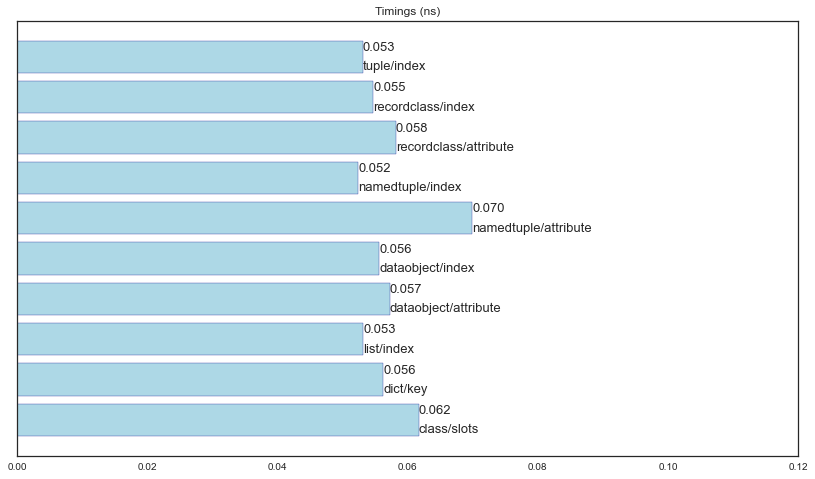

In [17]:
keys1 = list(sorted(d1.keys()))
n1 = len(d1)

plt.figure(figsize=(14,8))
plt.barh(range(n1), [d1[key] for key in keys1], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys1):
    plt.text(d1[key], i+0.15, '%.3f'%d1[key], fontdict={'size':13})
    plt.text(d1[key], i-0.33, labels1[key], fontdict={'size':13})
plt.yticks([],[])
plt.xlim(0,0.12)
plt.title('Timings (ns)')
plt.minorticks_on()
plt.savefig('recordclass_timings.png')
plt.show()

In [18]:
d2 = dict(
 nt = sizeof(nt),  
 rc = sizeof(rc),  
 do = sizeof(do),
 cs = sizeof(b),
 tp = sizeof(d),
)

labels2 = dict(
    nt = 'namedtuple',
    rc = 'recordclass',
    do = 'dataobject',
    cs = 'class/slots',
    tp = 'tuple',
)

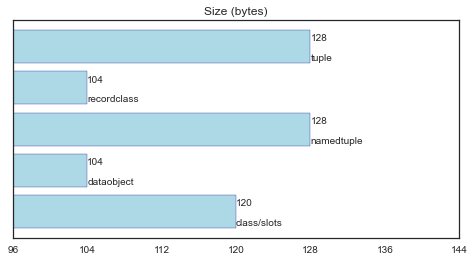

In [19]:
keys2 = list(sorted(d2.keys()))
n2 = len(d2)

plt.figure(figsize=(8,4))
plt.barh(range(n2), [d2[key] for key in keys2], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys2):
    plt.text(d2[key], i+0.15, '%d'%d2[key])
    plt.text(d2[key], i-0.33, labels2[key])
plt.yticks([],[])
plt.title('Size (bytes)')
plt.xlim(96,144)
plt.xticks([96,104,112,120,128,136,144])
plt.savefig('recordclass_memory.png')
plt.show()

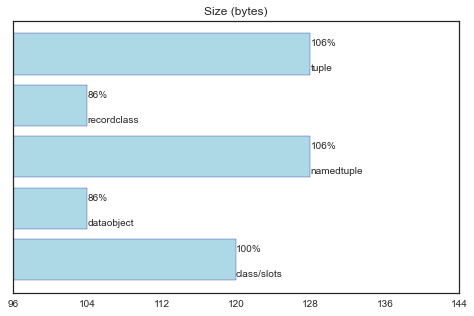

In [20]:
B = 120

plt.figure(figsize=(8,5))
plt.barh(range(n2), [d2[key] for key in keys2], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys2):
    v = (d2[key] / B) * 100
    plt.text(d2[key], i+0.15, '%d%%'% v)
    plt.text(d2[key], i-0.33, labels2[key])
plt.yticks([],[])
plt.title('Size (bytes)')
plt.xlim(96,144)
plt.xticks([96,104,112,120,128,136,144])
plt.show()

Here is the table for sizes comparisons:

In [21]:
import pandas as pd

df = pd.DataFrame(
    [(sizeof(rc), 
      sizeof(nt),
      sizeof(b),
      sizeof(do),
     )
    ], columns=[
        'recordclass', 'namedtuple', 'class + __slots__', 
        'dataobject'], index=['size'])
df

,recordclass,namedtuple,class + __slots__,dataobject
size,104,128,120,104
